In [21]:
import numpy as np 

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import math 
from tqdm import tqdm

In [22]:
def get_data(x_path, y_path):

    x = x_path
    y = y_path

    y = np.load(y_path)
    x = np.load(x_path)
    
    x = 2*(0.5 - x/255)
    return x, y

def get_metric(y_true, y_pred):

    results = classification_report(y_pred, y_true)
    print(results)



In [23]:
x_train_path = "D:/IIT Delhi Softwares-Documents/Sem2324/COL774/Assignment-3/q2/part b/x_train.npy"
y_train_path = "D:/IIT Delhi Softwares-Documents/Sem2324/COL774/Assignment-3/q2/part b/y_train.npy"

x_test_path = "D:/IIT Delhi Softwares-Documents/Sem2324/COL774/Assignment-3/q2/part b/x_test.npy"
y_test_path = "D:/IIT Delhi Softwares-Documents/Sem2324/COL774/Assignment-3/q2/part b/y_test.npy"

X_train, y_train = get_data(x_train_path, y_train_path)
X_test, y_test = get_data(x_test_path, y_test_path)


label_encoder = OneHotEncoder(sparse_output = False)
label_encoder.fit(np.expand_dims(y_train, axis = -1))


y_train_onehot = label_encoder.transform(np.expand_dims(y_train, axis = -1))
y_test_onehot = label_encoder.transform(np.expand_dims(y_test, axis = -1))



In [24]:
losses=[]

### Part 1(a) 

In [25]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size= input_size
        self.hidden_layers= hidden_layers
        self.output_size= output_size
        self.weights, self.biases= self.initialize_weights_and_biases()
        
    def initialize_weights_and_biases(self):
        layers= [self.input_size] + self.hidden_layers + [self.output_size]
        weights= [np.random.randn(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
        biases= [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]
        return weights, biases

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    

    def softmax(self, x):
        exp_x= np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward(self, X):
        self.z= []
        self.a= [X]
        for i in range(len(self.weights) - 1):
            z= np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            a= self.sigmoid(z)
            self.z.append(z)
            self.a.append(a)
        logits= np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        probabilities= self.softmax(logits)
        return probabilities

    def backward(self, X, y, learning_rate, adaptive, epoch):
        m= X.shape[0]
        delta_weights= [np.zeros(w.shape) for w in self.weights]
        delta_biases= [np.zeros(b.shape) for b in self.biases]

        probabilities= self.forward(X)

        error= probabilities - y
        for i in range(len(self.weights) - 1, -1, -1):
            delta_weights[i]= np.dot(self.a[i].T, error) / m
            delta_biases[i]= np.sum(error, axis=0) / m
            if i > 0:
                error= np.dot(error, self.weights[i].T) * (self.a[i] * (1 - self.a[i]))

        for i in range(len(self.weights)):

            self.weights[i] -= learning_rate * delta_weights[i]
            self.biases[i] -= learning_rate * delta_biases[i]
            
        if adaptive== True:
            if learning_rate<=1e-10:
                learning_rate= 1e-10
            else:
                learning_rate= learning_rate/ (math.sqrt(epoch))

    def train(self, X, y, num_epochs, learning_rate, batch_size,adaptive, gamma=25, epsilon= 1e-4):
        movingAverage = float("inf")
        flag=0
        for epoch in tqdm(range(1,num_epochs)):
            for i in range(0, X.shape[0], batch_size):
                X_batch= X[i:i+batch_size]
                y_batch= y[i:i+batch_size]
                loss1= self.cross_entropy_loss(y_batch, self.forward(X_batch))
                losses.append(loss1)
                self.backward(X_batch, y_batch, learning_rate, adaptive, epoch)
                
                if epoch>=gamma:
                    prevAverage=movingAverage
                    movingAverage =np.mean(losses[epoch-gamma :epoch +1])
                    
                    if abs(movingAverage-prevAverage) <epsilon:
                        flag=1
                        print(f"Converged at epoch {epoch}. Moving average loss: {movingAverage}")
                        break
            if flag ==1:
                break
                

    def one_hot_encode(self, y, num_classes):
        return np.eye(num_classes)[y]

    def cross_entropy_loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)
    
    def predict(self,X):
        probs= self.forward(X)
        y_pred= np.argmax(probs, axis=1)
        return y_pred +1
    
    def accuracy(self,y,y_pred):
        return np.sum(y== y_pred)/ len(y)
    
    def evaluate_model(self,X,y):
        y_pred= self.predict(X)
        precision= precision_score(y,y_pred, average="weighted",zero_division=1)
        recall= recall_score(y,y_pred, average="weighted",zero_division=1)
        f1= f1_score(y,y_pred, average="weighted",zero_division=1)
        accuracy= self.accuracy(y,y_pred)
        
        return precision, recall, accuracy, f1 
        


In [26]:
losses=[]
input_size = 1024
hidden_layers = [100,50]
output_size = 5
num_epochs = 50
learning_rate = 0.01
batch_size = 32

model = NeuralNetwork(input_size, hidden_layers, output_size)

model.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, False)

precision_train, recall_train, accuracy_train, f1_train= model.evaluate_model(X_train, y_train)

precision_test, recall_test, accuracy_test, f1_test= model.evaluate_model(X_test, y_test)


print(f"Train Precision  is: {precision_train: .2f}")
print(f"Train Recall  is: {recall_train: .2f}")
print(f"Train Accuracy is: {100* accuracy_train: .2f}%")
print(f"Train F1 Score is: {f1_train}")
print(f"\n")
print(f"Test Precision is: {precision_test: .2f}")
print(f"Test Recall is: {recall_test: .2f}")
print(f"Test Accuracy is: {100* accuracy_test: .2f}%")
print(f"Test F1 Score is: {f1_test}")
print(f"\n")



 49%|████▉     | 24/49 [00:20<00:21,  1.16it/s]

Converged at epoch 25. Moving average loss: 3.986538354031892
Train Precision  is:  0.54
Train Recall  is:  0.56
Train Accuracy is:  56.11%
Train F1 Score is: 0.5381487592367412


Test Precision is:  0.55
Test Recall is:  0.56
Test Accuracy is:  56.00%
Test F1 Score is: 0.5412326383969562




### Part 1(b) 

 24%|██▍       | 24/99 [00:04<00:13,  5.36it/s]


Converged at epoch 25. Moving average loss: 1.609666226827252
For Single Hidden Layer with number of neurons: 1
Train Precision  is:  0.64
Train Recall  is:  0.19
Train Accuracy is:  19.18%
Train F1 Score is: 0.06913578134991787


Test Precision is:  0.65
Test Recall is:  0.17
Test Accuracy is:  16.80%
Test F1 Score is: 0.05595642585043106




 24%|██▍       | 24/99 [00:02<00:07, 10.14it/s]


Converged at epoch 25. Moving average loss: 1.8027227403389867
For Single Hidden Layer with number of neurons: 5
Train Precision  is:  0.43
Train Recall  is:  0.46
Train Accuracy is:  46.36%
Train F1 Score is: 0.37550133026753046


Test Precision is:  0.45
Test Recall is:  0.47
Test Accuracy is:  47.10%
Test F1 Score is: 0.39281707534352767




 24%|██▍       | 24/99 [00:08<00:25,  2.95it/s]


Converged at epoch 25. Moving average loss: 1.8717797479674445
For Single Hidden Layer with number of neurons: 10
Train Precision  is:  0.48
Train Recall  is:  0.51
Train Accuracy is:  50.71%
Train F1 Score is: 0.4539752707178853


Test Precision is:  0.50
Test Recall is:  0.52
Test Accuracy is:  52.10%
Test F1 Score is: 0.4765932232621346




 24%|██▍       | 24/99 [00:12<00:40,  1.87it/s]


Converged at epoch 25. Moving average loss: 5.238594904787082
For Single Hidden Layer with number of neurons: 50
Train Precision  is:  0.49
Train Recall  is:  0.52
Train Accuracy is:  52.05%
Train F1 Score is: 0.4884147666213301


Test Precision is:  0.47
Test Recall is:  0.49
Test Accuracy is:  48.70%
Test F1 Score is: 0.46146468635813476




 24%|██▍       | 24/99 [00:16<00:52,  1.44it/s]


Converged at epoch 25. Moving average loss: 2.7299951896652455
For Single Hidden Layer with number of neurons: 100
Train Precision  is:  0.51
Train Recall  is:  0.53
Train Accuracy is:  53.15%
Train F1 Score is: 0.5186811825608705


Test Precision is:  0.51
Test Recall is:  0.52
Test Accuracy is:  52.00%
Test F1 Score is: 0.5104563752192901




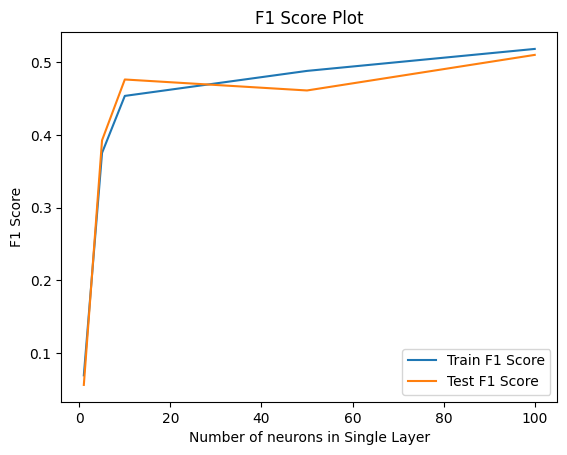

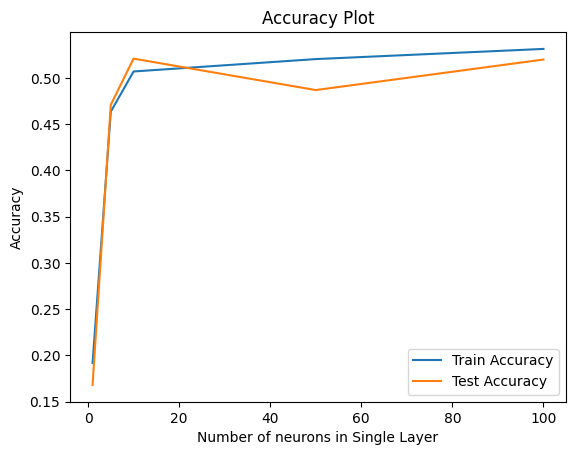

In [27]:
hidden_layer_list= [1, 5, 10, 50, 100]

train_acc_list=[]
test_acc_list=[]

f1_score_train_list=[]
f1_score_test_list=[]

for hidden_layer in hidden_layer_list:
    losses=[]
    input_size = 1024
    hidden_layers= [hidden_layer]
    output_size = 5
    num_epochs = 100
    learning_rate = 0.01
    batch_size = 32
    
    model = NeuralNetwork(input_size, hidden_layers, output_size)

    model.train(X_train, y_train_onehot, num_epochs, learning_rate,batch_size, False)
    
    precision_train, recall_train, accuracy_train, f1_train= model.evaluate_model(X_train, y_train)

    precision_test, recall_test, accuracy_test, f1_test= model.evaluate_model(X_test, y_test)
    
    f1_score_train_list.append(f1_train)
    f1_score_test_list.append(f1_test)
    
    train_acc_list.append(accuracy_train)
    test_acc_list.append(accuracy_test)

    print(f"For Single Hidden Layer with number of neurons: {hidden_layer}")
    print(f"Train Precision  is: {precision_train: .2f}")
    print(f"Train Recall  is: {recall_train: .2f}")
    print(f"Train Accuracy is: {100* accuracy_train: .2f}%")
    print(f"Train F1 Score is: {f1_train}")
    print(f"\n")
    print(f"Test Precision is: {precision_test: .2f}")
    print(f"Test Recall is: {recall_test: .2f}")
    print(f"Test Accuracy is: {100* accuracy_test: .2f}%")
    print(f"Test F1 Score is: {f1_test}")
    print(f"\n")
    
    
    
plt.plot(hidden_layer_list,f1_score_train_list, label= "Train F1 Score")
plt.title("F1 Score Plot")
plt.xlabel("Number of neurons in Single Layer")
plt.ylabel("F1 Score")
plt.legend()

plt.plot(hidden_layer_list,f1_score_test_list, label= "Test F1 Score")
plt.legend()

plt.show()


plt.plot(hidden_layer_list,train_acc_list, label= "Train Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Number of neurons in Single Layer")
plt.ylabel("Accuracy")
plt.legend()

plt.plot(hidden_layer_list,test_acc_list, label= "Test Accuracy")
plt.legend()

plt.show()


    

### Part 1(c)

 49%|████▉     | 24/49 [00:17<00:18,  1.37it/s]


Converged at epoch 25. Moving average loss: 4.120958209495594
For Structure: [512]
Train Precision  is:  0.55
Train Recall  is:  0.56
Train Accuracy is:  56.17%
Train F1 Score is: 0.5483624934598018


Test Precision is:  0.54
Test Recall is:  0.55
Test Accuracy is:  55.30%
Test F1 Score is: 0.5393815447991831




 49%|████▉     | 24/49 [00:20<00:21,  1.17it/s]


Converged at epoch 25. Moving average loss: 2.595902379956847
For Structure: [512, 256]
Train Precision  is:  0.53
Train Recall  is:  0.55
Train Accuracy is:  55.31%
Train F1 Score is: 0.5310076168156022


Test Precision is:  0.51
Test Recall is:  0.54
Test Accuracy is:  53.70%
Test F1 Score is: 0.5180737929329777




 49%|████▉     | 24/49 [00:18<00:19,  1.31it/s]


Converged at epoch 25. Moving average loss: 4.766117810973714
For Structure: [512, 256, 128]
Train Precision  is:  0.55
Train Recall  is:  0.57
Train Accuracy is:  56.56%
Train F1 Score is: 0.5536874928530369


Test Precision is:  0.57
Test Recall is:  0.58
Test Accuracy is:  57.70%
Test F1 Score is: 0.5695987507641529




 49%|████▉     | 24/49 [00:18<00:18,  1.33it/s]


Converged at epoch 25. Moving average loss: 4.477787409775342
For Structure: [512, 256, 128, 64]
Train Precision  is:  0.56
Train Recall  is:  0.57
Train Accuracy is:  57.25%
Train F1 Score is: 0.5557361318953892


Test Precision is:  0.56
Test Recall is:  0.56
Test Accuracy is:  56.50%
Test F1 Score is: 0.5556787044565433


Structure 0 stands for Strucure: [512]
Structure 1 stands for Strucure: [512, 256]
Structure 2 stands for Strucure: [512, 256, 128]
Structure 3 stands for Strucure: [512, 256, 128, 64]


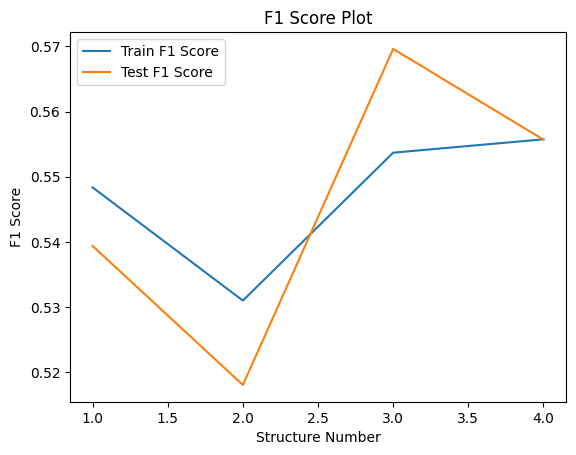

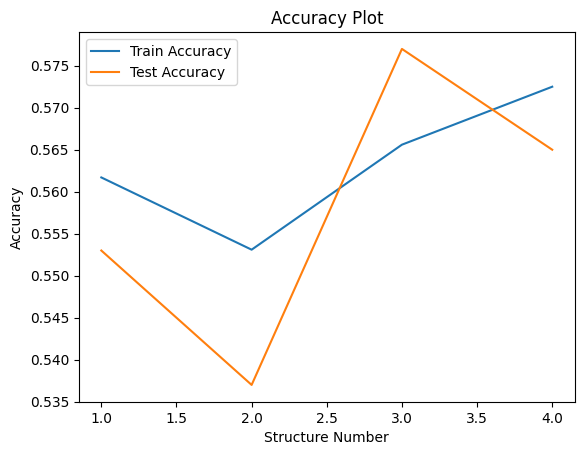

In [28]:
hidden_layer_depth_list= [[512],[512, 256], [512, 256, 128], [512, 256, 128, 64]]



train_acc_list=[]
test_acc_list=[]

f1_score_train_list=[]
f1_score_test_list=[]

for hidden_layer_depth in hidden_layer_depth_list:
    losses=[]
    input_size = 1024
    hiden_layers= hidden_layer_depth
    output_size = 5
    num_epochs = 50
    learning_rate = 0.01
    batch_size = 32
    
    model = NeuralNetwork(input_size, hidden_layers, output_size)

    model.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, False)
    
    precision_train, recall_train, accuracy_train, f1_train= model.evaluate_model(X_train, y_train)

    precision_test, recall_test, accuracy_test, f1_test= model.evaluate_model(X_test, y_test)
    
    
    f1_score_train_list.append(f1_train)
    f1_score_test_list.append(f1_test)
    
    train_acc_list.append(accuracy_train)
    test_acc_list.append(accuracy_test)

    print(f"For Structure: {hidden_layer_depth}")
    print(f"Train Precision  is: {precision_train: .2f}")
    print(f"Train Recall  is: {recall_train: .2f}")
    print(f"Train Accuracy is: {100* accuracy_train: .2f}%")
    print(f"Train F1 Score is: {f1_train}")
    print(f"\n")
    print(f"Test Precision is: {precision_test: .2f}")
    print(f"Test Recall is: {recall_test: .2f}")
    print(f"Test Accuracy is: {100* accuracy_test: .2f}%")
    print(f"Test F1 Score is: {f1_test}")
    print(f"\n")
    


for i in range(4):
    print(f"Structure {i} stands for Strucure: {hidden_layer_depth_list[i]}")
    
structure_list=[1,2,3,4]

plt.plot(structure_list,f1_score_train_list, label= "Train F1 Score")
plt.title("F1 Score Plot")
plt.xlabel("Structure Number")
plt.ylabel("F1 Score")
plt.legend()

plt.plot(structure_list,f1_score_test_list, label= "Test F1 Score")
plt.legend()

plt.show()



plt.plot(structure_list,train_acc_list, label= "Train Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Structure Number")
plt.ylabel("Accuracy")
plt.legend()

plt.plot(structure_list,test_acc_list, label= "Test Accuracy")
plt.legend()

plt.show()
    

### Part 1(d)

 49%|████▉     | 24/49 [00:18<00:19,  1.29it/s]


Converged at epoch 25. Moving average loss: 5.629562546130019
For Structure: [512]
Train Precision  is:  0.55
Train Recall  is:  0.57
Train Accuracy is:  57.26%
Train F1 Score is: 0.55531555499858


Test Precision is:  0.55
Test Recall is:  0.56
Test Accuracy is:  56.40%
Test F1 Score is: 0.5475593496516021




 49%|████▉     | 24/49 [00:17<00:17,  1.39it/s]


Converged at epoch 25. Moving average loss: 5.5280540392343775
For Structure: [512, 256]
Train Precision  is:  0.52
Train Recall  is:  0.54
Train Accuracy is:  53.85%
Train F1 Score is: 0.5183500167069125


Test Precision is:  0.50
Test Recall is:  0.51
Test Accuracy is:  51.30%
Test F1 Score is: 0.49809975457910005




 49%|████▉     | 24/49 [00:17<00:18,  1.39it/s]


Converged at epoch 25. Moving average loss: 5.941763889337632
For Structure: [512, 256, 128]
Train Precision  is:  0.56
Train Recall  is:  0.57
Train Accuracy is:  57.00%
Train F1 Score is: 0.5578629507770232


Test Precision is:  0.57
Test Recall is:  0.58
Test Accuracy is:  57.80%
Test F1 Score is: 0.5675347533017294




 49%|████▉     | 24/49 [00:17<00:18,  1.33it/s]


Converged at epoch 25. Moving average loss: 3.357916373276398
For Structure: [512, 256, 128, 64]
Train Precision  is:  0.52
Train Recall  is:  0.55
Train Accuracy is:  54.50%
Train F1 Score is: 0.5212020738383171


Test Precision is:  0.54
Test Recall is:  0.55
Test Accuracy is:  55.40%
Test F1 Score is: 0.535770529705901


Structure 0 stands for Strucure: [512]
Structure 1 stands for Strucure: [512, 256]
Structure 2 stands for Strucure: [512, 256, 128]
Structure 3 stands for Strucure: [512, 256, 128, 64]


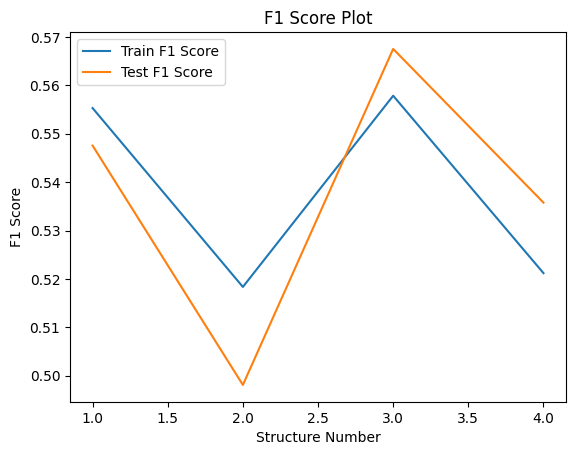

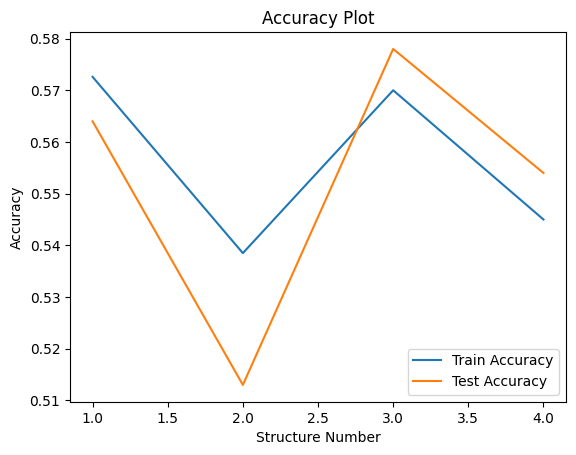

In [29]:
hidden_layer_depth_list= [[512],[512, 256], [512, 256, 128], [512, 256, 128, 64]]



train_acc_list=[]
test_acc_list=[]

f1_score_train_list=[]
f1_score_test_list=[]

for hidden_layer_depth in hidden_layer_depth_list:
    losses=[]
    input_size = 1024
    hiden_layers= hidden_layer_depth
    output_size = 5
    num_epochs = 50
    learning_rate = 0.01
    batch_size = 32
    
    model = NeuralNetwork(input_size, hidden_layers, output_size)

    model.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, True)
    
    precision_train, recall_train, accuracy_train, f1_train= model.evaluate_model(X_train, y_train)

    precision_test, recall_test, accuracy_test, f1_test= model.evaluate_model(X_test, y_test)
    
    
    f1_score_train_list.append(f1_train)
    f1_score_test_list.append(f1_test)
    
    train_acc_list.append(accuracy_train)
    test_acc_list.append(accuracy_test)

    print(f"For Structure: {hidden_layer_depth}")
    print(f"Train Precision  is: {precision_train: .2f}")
    print(f"Train Recall  is: {recall_train: .2f}")
    print(f"Train Accuracy is: {100* accuracy_train: .2f}%")
    print(f"Train F1 Score is: {f1_train}")
    print(f"\n")
    print(f"Test Precision is: {precision_test: .2f}")
    print(f"Test Recall is: {recall_test: .2f}")
    print(f"Test Accuracy is: {100* accuracy_test: .2f}%")
    print(f"Test F1 Score is: {f1_test}")
    print(f"\n")
    


for i in range(4):
    print(f"Structure {i} stands for Strucure: {hidden_layer_depth_list[i]}")
    
structure_list=[1,2,3,4]

plt.plot(structure_list,f1_score_train_list, label= "Train F1 Score")
plt.title("F1 Score Plot")
plt.xlabel("Structure Number")
plt.ylabel("F1 Score")
plt.legend()

plt.plot(structure_list,f1_score_test_list, label= "Test F1 Score")
plt.legend()

plt.show()



plt.plot(structure_list,train_acc_list, label= "Train Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Structure Number")
plt.ylabel("Accuracy")
plt.legend()

plt.plot(structure_list,test_acc_list, label= "Test Accuracy")
plt.legend()

plt.show()
    

### Part 1(e)

In [30]:
import numpy as np

class NeuralNetwork2:
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size= input_size
        self.hidden_layers= hidden_layers
        self.output_size= output_size
        self.weights, self.biases= self.initialize_weights_and_biases()
        
    def initialize_weights_and_biases(self):
        layers= [self.input_size] + self.hidden_layers + [self.output_size]
        weights= [np.random.randn(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
        biases= [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]
        return weights, biases

    
    def relu(self,x):
        return np.maximum(0,x)
    
    def relu_derivative(self,x):
        return np.where(x>=0, 1, 1e-7)

    def softmax(self, x):
        exp_x= np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward(self, X):
        self.z= []
        self.a= [X]
        for i in range(len(self.weights) - 1):
            net= np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            act= np.clip(self.relu(net), -10,10)
            self.z.append(net)
            self.a.append(act)
        logits= np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        probabilities= self.softmax(logits)
        return probabilities

    def backward(self, X, y, learning_rate, adaptive, epoch):
        m= X.shape[0]
        delta_weights= [np.zeros(w.shape) for w in self.weights]
        delta_biases= [np.zeros(b.shape) for b in self.biases]

        probabilities= self.forward(X)

        error= probabilities - y
        for i in range(len(self.weights) - 1, -1, -1):
            delta_weights[i]= np.dot(self.a[i].T, error) / m
            delta_biases[i]= np.sum(error, axis=0) / m
            if i > 0:
                error= np.dot(error, self.weights[i].T) * (self.relu_derivative(self.z[i-1]))

        for i in range(len(self.weights)):

            self.weights[i] -= learning_rate * delta_weights[i]
            self.biases[i] -= learning_rate * delta_biases[i]
            
        if adaptive== True:
            if learning_rate<=1e-10:
                learning_rate= 1e-10
            else:
                learning_rate= learning_rate/ (math.sqrt(epoch))

    def train(self, X, y, num_epochs, learning_rate, batch_size,adaptive, gamma=25, epsilon= 1e-4):
        movingAverage = float("inf")
        flag=0
        for epoch in tqdm(range(1,num_epochs)):
            for i in range(0, X.shape[0], batch_size):
                X_batch= X[i:i+batch_size]
                y_batch= y[i:i+batch_size]
                loss1= self.cross_entropy_loss(y_batch, self.forward(X_batch))
                losses.append(loss1)
                self.backward(X_batch, y_batch, learning_rate, adaptive, epoch)
                
                if epoch>=gamma:
                    prevAverage=movingAverage
                    movingAverage =np.mean(losses[epoch-gamma :epoch +1])
                    
                    if abs(movingAverage-prevAverage) <epsilon:
                        flag=1
                        print(f"Converged at epoch {epoch}. Moving average loss: {movingAverage}")
                        break
            if flag ==1:
                break
                

    def one_hot_encode(self, y, num_classes):
        return np.eye(num_classes)[y]

    def cross_entropy_loss(self, y_true, y_pred):
        # epsilon = 1e-9  
        # y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        return -np.sum(y_true * np.log2(y_pred))/ len(y_pred)
    
    def predict(self,X):
        probs= self.forward(X)
        y_pred= np.argmax(probs, axis=1)+1
        return y_pred
    
    def accuracy(self,y,y_pred):
        return np.sum(y== y_pred)/ len(y)
    
    def evaluate_model(self,X,y):
        y_pred= self.predict(X)
        precision= precision_score(y,y_pred, average="weighted",zero_division=1)
        recall= recall_score(y,y_pred, average="weighted",zero_division=1)
        f1= f1_score(y,y_pred, average="weighted",zero_division=1)
        accuracy= self.accuracy(y,y_pred)
        
        return precision, recall, accuracy, f1 
        


 49%|████▉     | 24/49 [00:16<00:16,  1.47it/s]


Converged at epoch 25. Moving average loss: 3.357916373276398
For Structure: [512]
Train Precision  is:  0.66
Train Recall  is:  0.64
Train Accuracy is:  63.90%
Train F1 Score is: 0.6358517730391974


Test Precision is:  0.66
Test Recall is:  0.63
Test Accuracy is:  62.70%
Test F1 Score is: 0.6247287476068694




 49%|████▉     | 24/49 [00:16<00:17,  1.47it/s]


Converged at epoch 25. Moving average loss: 3.357916373276398
For Structure: [512, 256]
Train Precision  is:  0.65
Train Recall  is:  0.64
Train Accuracy is:  64.03%
Train F1 Score is: 0.6374286153113219


Test Precision is:  0.65
Test Recall is:  0.62
Test Accuracy is:  62.10%
Test F1 Score is: 0.6203977285736257




 49%|████▉     | 24/49 [00:17<00:18,  1.34it/s]


Converged at epoch 25. Moving average loss: 3.357916373276398
For Structure: [512, 256, 128]
Train Precision  is:  0.63
Train Recall  is:  0.62
Train Accuracy is:  62.27%
Train F1 Score is: 0.6178602965857246


Test Precision is:  0.63
Test Recall is:  0.61
Test Accuracy is:  61.30%
Test F1 Score is: 0.6038854577949233




 49%|████▉     | 24/49 [00:16<00:17,  1.44it/s]


Converged at epoch 25. Moving average loss: 3.357916373276398
For Structure: [512, 256, 128, 64]
Train Precision  is:  0.65
Train Recall  is:  0.65
Train Accuracy is:  64.66%
Train F1 Score is: 0.6439778234962817


Test Precision is:  0.63
Test Recall is:  0.62
Test Accuracy is:  61.80%
Test F1 Score is: 0.6166163234951554


Structure 0 stands for Strucure: [512]
Structure 1 stands for Strucure: [512, 256]
Structure 2 stands for Strucure: [512, 256, 128]
Structure 3 stands for Strucure: [512, 256, 128, 64]


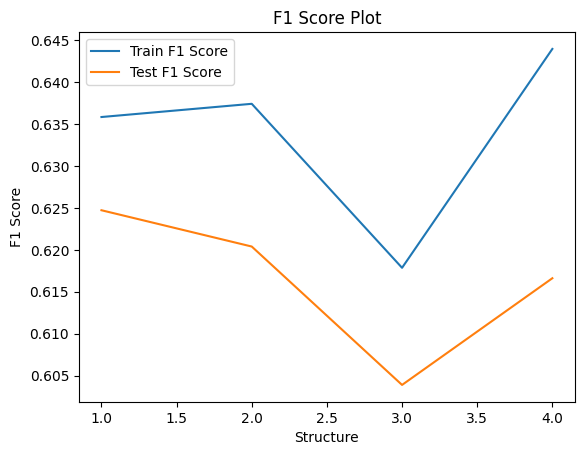

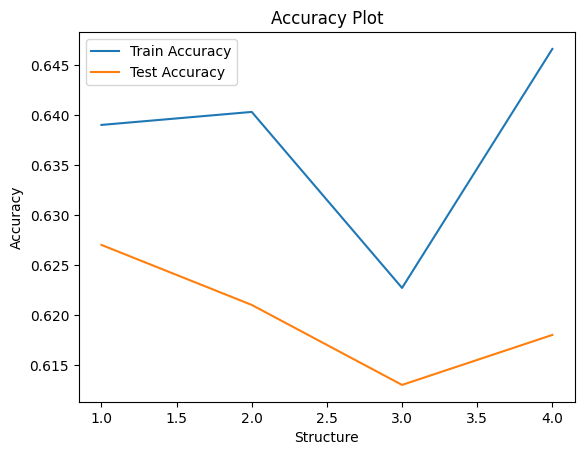

In [31]:
hidden_layer_depth_list= [[512],[512, 256], [512, 256, 128], [512, 256, 128, 64]]



train_acc_list=[]
test_acc_list=[]

f1_score_train_list=[]
f1_score_test_list=[]

for hidden_layer_depth in hidden_layer_depth_list:
    input_size = 1024
    hiden_layers= hidden_layer_depth
    output_size = 5
    num_epochs = 50
    learning_rate = 0.01
    batch_size = 32
    
    model = NeuralNetwork2(input_size, hidden_layers, output_size)

    model.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, False)
    
    precision_train, recall_train, accuracy_train, f1_train= model.evaluate_model(X_train, y_train)

    precision_test, recall_test, accuracy_test, f1_test= model.evaluate_model(X_test, y_test)
    
    
    f1_score_train_list.append(f1_train)
    f1_score_test_list.append(f1_test)
    
    train_acc_list.append(accuracy_train)
    test_acc_list.append(accuracy_test)

    print(f"For Structure: {hidden_layer_depth}")
    print(f"Train Precision  is: {precision_train: .2f}")
    print(f"Train Recall  is: {recall_train: .2f}")
    print(f"Train Accuracy is: {100* accuracy_train: .2f}%")
    print(f"Train F1 Score is: {f1_train}")
    print(f"\n")
    print(f"Test Precision is: {precision_test: .2f}")
    print(f"Test Recall is: {recall_test: .2f}")
    print(f"Test Accuracy is: {100* accuracy_test: .2f}%")
    print(f"Test F1 Score is: {f1_test}")
    print(f"\n")
    


for i in range(4):
    print(f"Structure {i} stands for Strucure: {hidden_layer_depth_list[i]}")
    
structure_list=[1,2,3,4]

plt.plot(structure_list,f1_score_train_list, label= "Train F1 Score")
plt.title("F1 Score Plot")
plt.xlabel("Structure")
plt.ylabel("F1 Score")
plt.legend()

plt.plot(structure_list,f1_score_test_list, label= "Test F1 Score")
plt.legend()

plt.show()



plt.plot(structure_list,train_acc_list, label= "Train Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Structure")
plt.ylabel("Accuracy")
plt.legend()

plt.plot(structure_list,test_acc_list, label= "Test Accuracy")
plt.legend()

plt.show()
    

### Part 1(f)

Accuracy: 0.558
Classification Report:
               precision    recall  f1-score   support

           1       0.76      0.91      0.83       229
           2       0.52      0.42      0.46       198
           3       0.42      0.34      0.37       199
           4       0.40      0.30      0.34       187
           5       0.55      0.77      0.64       187

    accuracy                           0.56      1000
   macro avg       0.53      0.55      0.53      1000
weighted avg       0.54      0.56      0.54      1000



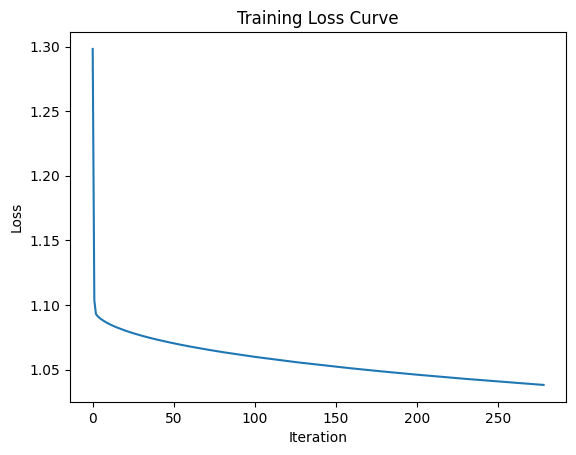

Accuracy: 0.593
Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.87      0.83       229
           2       0.56      0.49      0.52       198
           3       0.48      0.42      0.45       199
           4       0.44      0.37      0.40       187
           5       0.59      0.75      0.66       187

    accuracy                           0.59      1000
   macro avg       0.57      0.58      0.57      1000
weighted avg       0.58      0.59      0.58      1000



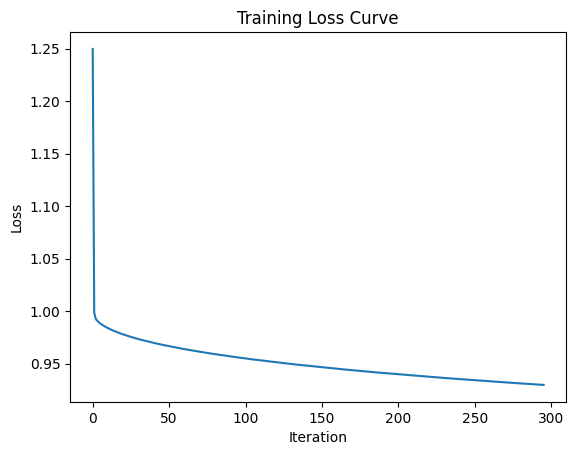

Accuracy: 0.605
Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.89      0.86       229
           2       0.60      0.55      0.57       198
           3       0.48      0.46      0.47       199
           4       0.42      0.39      0.40       187
           5       0.60      0.69      0.64       187

    accuracy                           0.60      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.60      0.60      0.60      1000



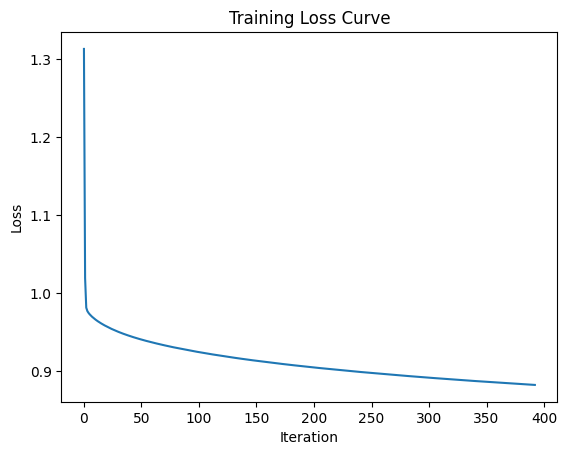

Accuracy: 0.612
Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.87      0.86       229
           2       0.59      0.58      0.58       198
           3       0.51      0.50      0.50       199
           4       0.43      0.40      0.42       187
           5       0.61      0.66      0.64       187

    accuracy                           0.61      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.61      0.61      0.61      1000



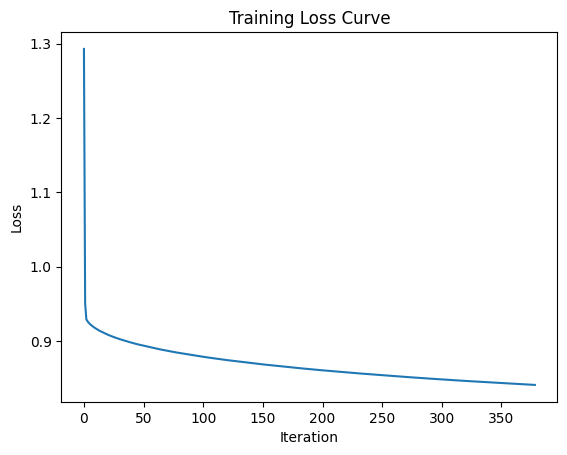

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
hidden_layer_depth_list= [(512),(512, 256), (512, 256, 128), (512, 256, 128, 64)]

for hidden_layer_depth in hidden_layer_depth_list:

    hidden_layer_sizes = hidden_layer_depth 
    activation = 'relu'
    solver = 'sgd'
    alpha = 0
    batch_size = 32
    learning_rate = 'invscaling'
    max_iter = 1000  
    tolerance = 1e-4  


    mlp = MLPClassifier(    
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        batch_size=batch_size,
        learning_rate=learning_rate,
        max_iter=max_iter,
        tol=tolerance,
        random_state=42  
    )
    
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_rep)


    plt.plot(mlp.loss_curve_)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()
    

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


class NeuralNetwork2(torch.nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(NeuralNetwork2, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.layers = self.initialize_layers()

    def initialize_layers(self):
        layers = [self.input_size] + self.hidden_layers + [self.output_size]
        modules = []
        for i in range(len(layers) - 1):
            modules.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                modules.append(nn.ReLU())
        return nn.Sequential(*modules)

    def forward(self, x):
        return torch.nn.functional.softmax(self.layers(x), dim=1)

def train(X, y, num_epochs, learning_rate, batch_size):
    input_size = X.shape[1]
    output_size = y.shape[1]
    model = NeuralNetwork2(input_size, [128, 64], output_size)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Convert data to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.argmax(y, axis=1)  # Convert one-hot encoded labels to class indices
    y = torch.tensor(y, dtype=torch.int64)

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    losses = []
    for epoch in range(num_epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    return model, losses

def predict_neural_network(model, X):
    X = torch.tensor(X, dtype=torch.float32)
    outputs = model(X)
    _, predictions = torch.max(outputs, dim=1)
    return predictions.numpy()

In [34]:
losses=[]

In [35]:
input_size = 1024
hidden_layers = [512,245, 128,64]
output_size = 5
num_epochs = 50
learning_rate = 0.001
batch_size = 32

# m = NeuralNetwork2(input_size, hidden_layers, output_size)

In [36]:
trained_model, losses=m.train(X_train, y_train_onehot,num_epochs, learning_rate, batch_size)

NameError: name 'm' is not defined